Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 250, 128)  │  3,840,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 248, 128)  │     49,280 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 247, 128)  │     65,664 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 246, 128)  │     82,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     49,280 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        387 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,086,659 (15.59 MB)

 Trainable params: 4,086,659 (15.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 113s 557ms/step - accuracy: 0.4231 - loss: 1.0499 - val_accuracy: 0.6141 - val_loss: 0.8245
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 142s 555ms/step - accuracy: 0.6893 - loss: 0.7070 - val_accuracy: 0.6209 - val_loss: 0.8423
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 151s 602ms/step - accuracy: 0.8203 - loss: 0.4707 - val_accuracy: 0.6187 - val_loss: 0.9222
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step

Label mapping: {0: 0, 1: 1, 2: 2}

Classification Report:
              precision    recall  f1-score   support

           0     0.7486    0.6432    0.6919      1236
           1     0.5084    0.6713    0.5786      1217
           2     0.7092    0.5844    0.6408      1227

    accuracy                         0.6329      3680
   macro avg     0.6554    0.6330    0.6371      3680
weighted avg     0.6560    0.6329    0.6374      3680


Confusion Matrix:
[[795 379  62]
 [168 817 232]
 [ 99 411 717]]


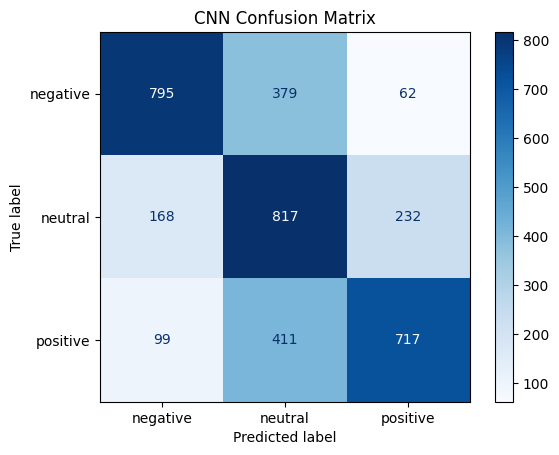

Macro AUC (OvR): 0.8160147418369231


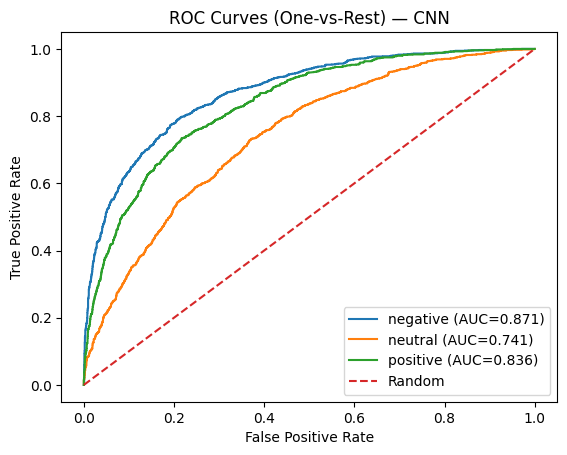

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import label_binarize

# SETTINGS (instead of argparse)
DATA_PATH = "../../datasets/amazon_user_reviews_text_sentiment.parquet"

TEXT_COL = "text_cleaned"
LABEL_COL = "sentiment"

VOCAB_SIZE = 30000
MAX_LEN = 250
EMB_DIM = 128

FILTERS = 128
KERNEL_SIZES = [3, 4, 5]
DROPOUT = 0.5
DENSE_UNITS = 128

EPOCHS = 20
BATCH_SIZE = 64


# LOAD DATA
df = pd.read_parquet(DATA_PATH)

texts = df[TEXT_COL].astype(str).tolist()
y_raw = df[LABEL_COL].astype(int).to_numpy()


# Label mapping
unique = np.sort(np.unique(y_raw))
label_map = {int(v): i for i, v in enumerate(unique)}
y = np.array([label_map[int(v)] for v in y_raw])


# Split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)


# TOKENIZE
tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tok.fit_on_texts(X_train_texts)

X_train = pad_sequences(tok.texts_to_sequences(X_train_texts), maxlen=MAX_LEN, padding="post")
X_test  = pad_sequences(tok.texts_to_sequences(X_test_texts),  maxlen=MAX_LEN, padding="post")


# BUILD CNN
inputs = tf.keras.Input(shape=(MAX_LEN,))
x = layers.Embedding(VOCAB_SIZE, EMB_DIM)(inputs)

convs = []
for k in KERNEL_SIZES:
    c = layers.Conv1D(FILTERS, k, activation="relu")(x)
    c = layers.GlobalMaxPooling1D()(c)
    convs.append(c)

x = layers.Concatenate()(convs)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(DENSE_UNITS, activation="relu")(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


# TRAIN
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)


# EVALUATE
probs = model.predict(X_test)
pred = np.argmax(probs, axis=1)

print("\nLabel mapping:", label_map)
print("\nClassification Report:")
print(classification_report(y_test, pred, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, pred))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["negative","neutral","positive"])
disp.plot(values_format="d", cmap="Blues")
plt.title("CNN Confusion Matrix")
plt.show()

# binarize y_test for OvR ROC
y_test_bin = label_binarize(y_test, classes=[0,1,2])

# macro AUC (OvR)
macro_auc = roc_auc_score(y_test_bin, probs, multi_class="ovr", average="macro")
print("Macro AUC (OvR):", macro_auc)

# plot ROC for each class
plt.figure()
class_names = ["negative","neutral","positive"]

for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")

plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest) — CNN")
plt.legend()
plt.show()


MODEL EVALUATION METRICS
Accuracy:  0.6329
Precision: 0.6560
Recall:    0.6329
F1-Score:  0.6374

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1236
           1       0.51      0.67      0.58      1217
           2       0.71      0.58      0.64      1227

    accuracy                           0.63      3680
   macro avg       0.66      0.63      0.64      3680
weighted avg       0.66      0.63      0.64      3680

ROC=AUC REPORT
AUC score: 0.8163514722740918


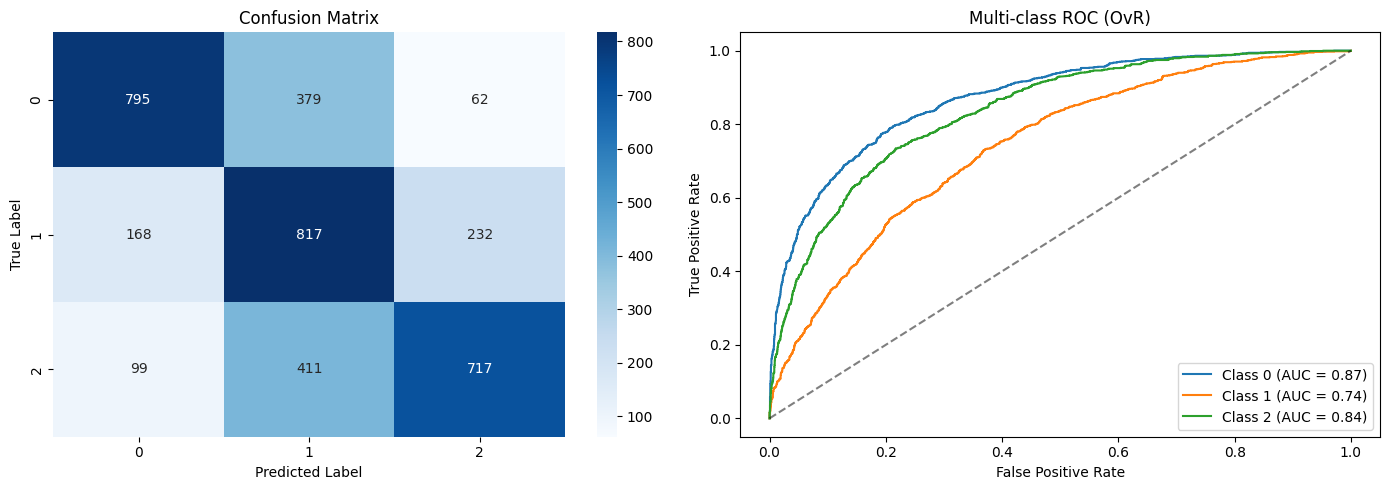

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../'))

# ModelEvaluation
from ModelEvaluation.ModelEvaluation import ModelEvaluation
# Model Evaluation

evaluator = ModelEvaluation()
evaluator.run_pipeline(y_test, pred, probs)

In [ ]:
import json

# model.save("textcnn_model.keras")

# with open("tokenizer.json", "w") as f:
    # f.write(tok.to_json())

# with open("label_map.json", "w") as f:
    # json.dump(label_map, f)